In [1]:
!git clone https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch.git
!mkdir data
!mv Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/testing/* data/
!mv Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/training/* data/

Cloning into 'Facial-Similarity-with-Siamese-Networks-in-Pytorch'...
remote: Enumerating objects: 550, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 550 (delta 6), reused 18 (delta 6), pack-reused 532
Receiving objects: 100% (550/550), 6.32 MiB | 12.90 MiB/s, done.
Resolving deltas: 100% (27/27), done.
mkdir: cannot create directory ‘data’: File exists


In [2]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from matplotlib import pyplot as plt
import glob
from sklearn.metrics import accuracy_score

from aijack.attack import MI_FACE
from aijack.defense import GeneralMomentAccountant, DPSGDManager
from aijack.utils import NumpyDataset

BASE = "data/"

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fla = nn.Flatten()
        self.fc = nn.Linear(112 * 92, 40)

    def forward(self, x):
        x = self.fla(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

In [4]:
imgs = []
labels = []
for i in range(1, 41):
    for j in range(1, 11):
        img = cv2.imread(BASE + f"s{i}/{j}.pgm", 0)
        imgs.append(img)
        labels.append(i - 1)

X = np.stack(imgs)
y = np.array(labels)


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = NumpyDataset(X, y, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [5]:
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0
    data_size = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.to(torch.int64))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        data_size += inputs.shape[0]

    # print(f"epoch {epoch}: loss is {running_loss/data_size}")


in_preds = []
in_label = []
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        outputs = net(inputs)
        in_preds.append(outputs)
        in_label.append(labels)
    in_preds = torch.cat(in_preds)
    in_label = torch.cat(in_label)
# print(
#     "Test Accuracy is: ",
#     accuracy_score(np.array(torch.argmax(in_preds, axis=1)), np.array(in_label)),
# )

epoch 0: loss is 0.916085814833641
epoch 1: loss is 0.8627295517921447
epoch 2: loss is 0.8016137629747391
epoch 3: loss is 0.7695482099056243
epoch 4: loss is 0.7418680799007416
epoch 5: loss is 0.7304996299743652
epoch 6: loss is 0.7186941093206406
epoch 7: loss is 0.7109037113189697
epoch 8: loss is 0.7087645703554153
epoch 9: loss is 0.704728022813797
epoch 10: loss is 0.7026552957296371
epoch 11: loss is 0.6997574293613433
epoch 12: loss is 0.6963995957374572
epoch 13: loss is 0.6928332716226577
epoch 14: loss is 0.6902176105976104
epoch 15: loss is 0.6899232405424118
epoch 16: loss is 0.6897992211580276
epoch 17: loss is 0.6897152304649353
epoch 18: loss is 0.6896520954370499
epoch 19: loss is 0.6895947146415711
epoch 20: loss is 0.6895408415794373
epoch 21: loss is 0.6895046854019165
epoch 22: loss is 0.6894655692577362
epoch 23: loss is 0.6894305884838104
epoch 24: loss is 0.6893972969055175
epoch 25: loss is 0.6893503129482269
epoch 26: loss is 0.6883105164766312
epoch 27: los

In [8]:
input_shape = (1, 1, 112, 92)
target_label = 11
lam = 0.03
num_itr = 1000

mi = MI_FACE(
    net,
    input_shape,
    target_label=target_label,
    num_itr=num_itr,
    lam=lam,
    log_interval=0,
)
x_result_1, log = mi.attack()

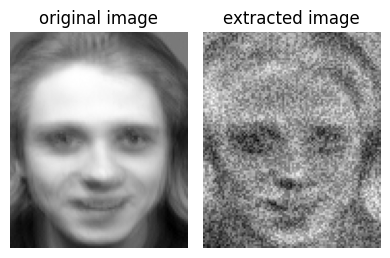

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))
axes[0].imshow(
    np.mean([cv2.imread(p, 0) for p in glob.glob(BASE + "s12/*.pgm")], axis=0),
    cmap="gray",
)
axes[0].axis("off")
axes[0].set_title("original image")
axes[1].imshow(x_result_1[0][0].detach().numpy(), cmap="gray")
axes[1].axis("off")
axes[1].set_title("extracted image")
fig.tight_layout()
fig.show()